In [1]:
from bs4 import BeautifulSoup
from collections import defaultdict
from ortools.linear_solver.pywraplp import Solver
from scipy.special import expit
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import requests


In [2]:
# Simulation parameters
MONTE_CARLO_ROUNDS = 10000

# Plot display parameters
ELO_SPACING = 20


In [3]:
# A description of result tiers and points for each tier (in a single GP leg)
tiers = ["winner", "runner-up", "semifinalist", "group runner-up", "group 3rd place", "group last"]
points = [13, 10, 7, 4, 2, 0]
max_points = max(points)

# A dict mapping tier to points received
tier_to_points = {tiers[i]: points[i] for i in range(len(tiers))}

# An array mapping index in leg standings to points received
place_to_points = [13, 10] + [7] * 2 + [4] * 4 + [2] * 4 + [0] * 4


In [4]:
name_to_rating = {
    "Ding Liren": 2799.0,
    "Levon Aronian": 2785,
    "Wesley So": 2778,
    "Shakhriyar Mamedyarov": 2771.2,
    "Anish Giri": 2772.8,
    "Richard Rapport": 2776.4,
    "Maxime Vachier-Lagrave": 2757.8,
    "Alexander Grischuk": 2742,
    "Leinier Dominguez": 2756,
    "Hikaru Nakamura": 2750,
    "Nikita Vitiugov": 2724.2,
    "Dmitry Andreikin": 2729.4,
    "Andrey Esipenko": 2723,
    "Vidit Gujrathi": 2722.6,
    "Pentala Harikrishna": 2705.2,
    "Yu Yangyi": 2710.4,
    "Daniil Dubov": 2711,
    "Vladimir Fedoseev": 2700.8,
    "Sam Shankland": 2709.2,
    "Radoslaw Wojtaszek": 2696.2,
    "Alexei Shirov": 2689.2,
    "Alexandr Predke": 2687.6,
    "Grigoriy Oparin": 2674.0,
    "Vincent Keymer": 2654.5,
    "Etienne Bacrot": 2637.8,
    "Amin Tabatabaei": 2632.4,
}
hikaru = "Hikaru Nakamura"


In [5]:
# Probabilities taken from https://chance.amstat.org/2020/09/chess/

prob_draw = lambda rwhite, rblack: expit(
    -1.627 + 0.0006955 * rwhite - 0.004668 * abs(rwhite - rblack)
)
prob_beats = lambda ra, rb: 1 / (1 + 10 ** ((rb - ra) / 400))
prob_win = lambda rwhite, rblack: prob_beats(rwhite, rblack) - prob_draw(rwhite, rblack) / 2


In [6]:
def sim_match(elo1, elo2):
    points = 0

    pdraw1 = prob_draw(elo1, elo2)
    pbeats1 = prob_beats(elo1, elo2)
    pwin1 = pbeats1 - pdraw1 / 2

    rand = random.random()
    if rand <= pwin1:
        points += 1
    elif rand > pwin1 + pdraw1:
        points -= 1

    pdraw2 = prob_draw(elo2, elo1)
    pbeats2 = prob_beats(elo2, elo1)
    pwin2 = pbeats2 - pdraw2 / 2

    rand = random.random()
    if rand <= pwin2:
        points -= 1
    elif rand > pwin2 + pdraw2:
        points += 1

    return points


def sim_group(inds, elos):
    n = len(inds)
    points = [0] * n
    for i in range(n):
        for j in range(i + 1, n):
            res = sim_match(elos[inds[i]], elos[inds[j]])
            points[i] += res
            points[j] -= res
    inds_rankings = list(sorted(range(n), key=lambda i: points[i], reverse=True))
    tiebreak = int(points[inds_rankings[0]] != points[inds_rankings[1]])
    while tiebreak == 0:
        ind0, ind1 = inds_rankings[0], inds_rankings[1]
        tiebreak = sim_match(elos[inds[ind0]], elos[inds[ind1]])
        if tiebreak < 0:
            inds_rankings[0], inds_rankings[1] = inds_rankings[1], inds_rankings[0]
    return [inds[i] for i in inds_rankings]


def sim_leg(elos, groups=None):
    n = len(elos)

    if groups is None:
        rand_inds = np.array(range(n))
        np.random.shuffle(rand_inds)
        groups = [list(g) for g in np.split(rand_inds, 4)]

    group_results = [sim_group(group, elos) for group in groups]

    rev_standings = []
    for group_place in range(3, 0, -1):
        for group_res in group_results:
            rev_standings.append(group_res[group_place])

    semis = [group_res[0] for group_res in group_results]
    semi1_res = sim_group(semis[:2], elos)
    semi2_res = sim_group(semis[2:], elos)
    rev_standings.append(semi1_res[1])
    rev_standings.append(semi2_res[1])
    finals = [semi1_res[0], semi2_res[0]]
    f_res = sim_group(finals, elos)
    rev_standings.append(f_res[1])
    rev_standings.append(f_res[0])

    leg_points = [0] * n
    for i, player in enumerate(reversed(rev_standings)):
        leg_points[player] = place_to_points[i]

    return leg_points


In [7]:
grand_prix_page = requests.get("https://www.chess.com/article/view/fide-grand-prix-2022")
grand_prix_soup = BeautifulSoup(grand_prix_page.text, "lxml")


In [8]:
# Leg 1

leg1_players_soup = grand_prix_soup.select(".standings_table")[2]
headers = []
for h in leg1_players_soup.find("tr").find_all("td"):
    title = h.text
    headers.append(title)
leg1_players_df = pd.DataFrame(
    [[i.text for i in row.find_all("td")] for row in leg1_players_soup.find_all("tr")[1:]],
    columns=headers,
)
leg1_players_df = leg1_players_df.drop(["Fed"], axis=1)
leg1_players_df["Player"] = leg1_players_df["Player"].apply(lambda n: n.replace("*", ""))
leg1_players_df["Rating"] = leg1_players_df["Player"].apply(lambda n: name_to_rating[n])

leg1_players_df["Leg 1 Points"] = pd.Series([4, 10, 2, 7, 7, 13, 4, 2, 3, 3, 2, 0, 4, 0, 0, 0])

leg1_players = leg1_players_df["Player"]

leg1_players_df


,Player,Rating,Leg 1 Points
0,Wesley So,2778.0,4
1,Levon Aronian,2785.0,10
2,Alexander Grischuk,2742.0,2
3,Richard Rapport,2776.4,7
4,Leinier Dominguez,2756.0,7
5,Hikaru Nakamura,2750.0,13
6,Andrey Esipenko,2723.0,4
7,Pentala Harikrishna,2705.2,2
8,Vidit Gujrathi,2722.6,3
9,Daniil Dubov,2711.0,3


In [9]:
# Leg 2 (simulated)

leg2_players_soup = grand_prix_soup.select(".standings_table")[5]
headers = []
for h in leg2_players_soup.find("tr").find_all("td"):
    title = h.text
    headers.append(title)
leg2_players_df = pd.DataFrame(
    [[i.text for i in row.find_all("td")] for row in leg2_players_soup.find_all("tr")[1:]],
    columns=headers,
)
leg2_players_df["Player"] = leg2_players_df["Player"].apply(lambda n: n.replace("*", ""))
leg2_players_df = leg2_players_df.drop(["Fed"], axis=1)
leg2_players_df["Rating"] = leg2_players_df["Player"].apply(lambda n: name_to_rating[n])

round2_elos = [float(elo) for elo in leg2_players_df["Rating"]]
leg2_players_df["Leg 2 Points"] = pd.Series([10, 7, 4, 0, 13, 7, 4, 0, 4, 0, 4, 2, 0, 2, 2, 2])

leg2_players = leg2_players_df["Player"]

leg2_players_df


,Player,Rating,Leg 2 Points
0,Dmitry Andreikin,2729.4,10
1,Anish Giri,2772.8,7
2,Shakhriyar Mamedyarov,2771.2,4
3,Alexander Grischuk,2742.0,0
4,Richard Rapport,2776.4,13
5,Maxime Vachier-Lagrave,2757.8,7
6,Nikita Vitiugov,2724.2,4
7,Pentala Harikrishna,2705.2,0
8,Vidit Gujrathi,2722.6,4
9,Yu Yangyi,2710.4,0


In [10]:
# Leg 3 (simulated)

leg3_players_soup = grand_prix_soup.select(".standings_table")[8]
headers = []
for h in leg3_players_soup.find("tr").find_all("td"):
    title = h.text
    headers.append(title)
leg3_players_df = pd.DataFrame(
    [[i.text for i in row.find_all("td")] for row in leg3_players_soup.find_all("tr")[1:]],
    columns=headers,
)
leg3_players_df["Player"] = leg3_players_df["Player"].apply(lambda n: n.replace("*", ""))
leg3_players_df.loc[leg3_players_df["Player"] == "Dmitry Andreikin", "Player"] = "Andrey Esipenko"
leg3_players_df = leg3_players_df.drop(["Fed"], axis=1)
leg3_players_df["Rating"] = leg3_players_df["Player"].apply(lambda n: name_to_rating[n])

round3_elos = [float(elo) for elo in leg3_players_df["Rating"]]
leg3_players_df["Leg 3 Points"] = pd.Series(sim_leg(round3_elos))

leg3_players = leg3_players_df["Player"]

leg3_groups = [[2, 6, 8, 13], [3, 5, 9, 14], [1, 4, 11, 12], [7, 0, 10, 15]]
leg3_groups_players = [
    [leg3_players_df.loc[idx, "Player"] for idx in group] for group in leg3_groups
]

print("Leg 3 Groups:")
for i, group in enumerate(leg3_groups):
    elos = [leg3_players_df["Rating"][p] for p in group]
    print(f"\tGroup {i+1} (avg. rating: {sum(elos)/len(elos):.1f}):")
    for gi, p in enumerate(group):
        print(f"\t - {leg3_players_df['Player'][p]} ({elos[gi]})")
    print("")

leg3_players_df


Leg 3 Groups:
	Group 1 (avg. rating: 2733.0):
	 - Levon Aronian (2785.0)
	 - Hikaru Nakamura (2750.0)
	 - Andrey Esipenko (2723.0)
	 - Grigoriy Oparin (2674.0)

	Group 2 (avg. rating: 2723.2):
	 - Shakhriyar Mamedyarov (2771.2)
	 - Leinier Dominguez (2756.0)
	 - Daniil Dubov (2711.0)
	 - Vincent Keymer (2654.5)

	Group 3 (avg. rating: 2733.2):
	 - Wesley So (2778.0)
	 - Maxime Vachier-Lagrave (2757.8)
	 - Sam Shankland (2709.2)
	 - Alexandr Predke (2687.6)

	Group 4 (avg. rating: 2709.9):
	 - Nikita Vitiugov (2724.2)
	 - Anish Giri (2772.8)
	 - Yu Yangyi (2710.4)
	 - Amin Tabatabaei (2632.4)



,Player,Rating,Leg 3 Points
0,Anish Giri,2772.8,7
1,Wesley So,2778.0,7
2,Levon Aronian,2785.0,13
3,Shakhriyar Mamedyarov,2771.2,4
4,Maxime Vachier-Lagrave,2757.8,4
5,Leinier Dominguez,2756.0,2
6,Hikaru Nakamura,2750.0,10
7,Nikita Vitiugov,2724.2,0
8,Andrey Esipenko,2723.0,4
9,Daniil Dubov,2711.0,2


In [11]:
def sim_grand_prix():
    leg3_players_df["Rating"] = leg3_players_df["Player"].apply(lambda n: name_to_rating[n])
    round3_elos = [float(elo) for elo in leg3_players_df["Rating"]]
    leg3_players_df["Leg 3 Points"] = pd.Series(sim_leg(round3_elos, groups=leg3_groups))

    leg2_cum_df = pd.merge(leg1_players_df, leg2_players_df, on="Player", how="outer")
    final_df = pd.merge(leg2_cum_df, leg3_players_df, on="Player", how="outer")
    final_df["Rating"] = final_df["Player"].apply(lambda n: name_to_rating[n])
    final_df["Leg 1 Points"] = final_df["Leg 1 Points"].fillna(0)
    final_df["Leg 2 Points"] = final_df["Leg 2 Points"].fillna(0)
    final_df["Leg 3 Points"] = final_df["Leg 3 Points"].fillna(0)
    final_df["Total Points"] = (
        final_df["Leg 1 Points"] + final_df["Leg 2 Points"] + final_df["Leg 3 Points"]
    )
    final_df = final_df[
        ["Player", "Rating", "Leg 1 Points", "Leg 2 Points", "Leg 3 Points", "Total Points"]
    ]
    final_df = final_df.sort_values(by="Total Points", ascending=False).reset_index(drop=True)
    final_df.index = final_df.index + 1
    return final_df


100%|██████████| 11/11 [16:14<00:00, 88.57s/it]


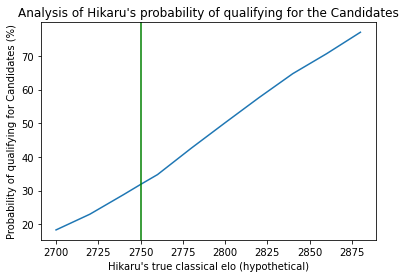

In [12]:
# Probability distribution of Hikaru candidates qualification


def prob_hikaru_qualifies(elo):
    orig_elo = name_to_rating[hikaru]
    name_to_rating[hikaru] = elo
    num_qualifies = 0
    for _ in range(MONTE_CARLO_ROUNDS):
        candidates_rows = sim_grand_prix()[:2]
        num_qualifies += int(any(row["Player"] == hikaru for _, row in candidates_rows.iterrows()))
    name_to_rating[hikaru] = orig_elo
    return num_qualifies / MONTE_CARLO_ROUNDS


hikaru_elo = np.sort(np.append(np.arange(2700, 2900, ELO_SPACING), name_to_rating[hikaru]))
candidates_prob = np.array([prob_hikaru_qualifies(elo) for elo in tqdm(hikaru_elo)])

plt.plot(hikaru_elo, candidates_prob * 100, label="Hikaru's Classical Elo (Hypothetical)")
plt.axvline(x=name_to_rating[hikaru], color="green")
plt.title("Analysis of Hikaru's probability of qualifying for the Candidates")
plt.xlabel("Hikaru's true classical elo (hypothetical)")
plt.ylabel("Probability of qualifying for Candidates (%)")
plt.savefig("hikaru_candidates_prob.png", facecolor="white")
plt.show()


In [13]:
# Average points per player

avg_final = sim_grand_prix().sort_values(by="Player").reset_index(drop=True)

for _ in range(MONTE_CARLO_ROUNDS - 1):
    final = sim_grand_prix().sort_values(by="Player").reset_index(drop=True)
    avg_final["Leg 1 Points"] += final["Leg 1 Points"]
    avg_final["Leg 2 Points"] += final["Leg 2 Points"]
    avg_final["Leg 3 Points"] += final["Leg 3 Points"]
    avg_final["Total Points"] += final["Total Points"]

avg_final["Leg 1 Points"] /= MONTE_CARLO_ROUNDS
avg_final["Leg 2 Points"] /= MONTE_CARLO_ROUNDS
avg_final["Leg 3 Points"] /= MONTE_CARLO_ROUNDS
avg_final["Total Points"] /= MONTE_CARLO_ROUNDS

avg_final = avg_final.sort_values(by="Total Points", ascending=False).reset_index(drop=True)
avg_final.index = avg_final.index + 1

print(
    f"Average points by player for the simulated FIDE Grand Prix (assuming Hikaru's true elo is {name_to_rating[hikaru]}):"
)
avg_final


Average points by player for the simulated FIDE Grand Prix (assuming Hikaru's true elo is 2750):


,Player,Rating,Leg 1 Points,Leg 2 Points,Leg 3 Points,Total Points
1,Richard Rapport,2776.4,7.0,13.0,0.0000,20.0000
2,Hikaru Nakamura,2750.0,13.0,0.0,4.4130,17.4130
3,Levon Aronian,2785.0,10.0,0.0,6.4484,16.4484
4,Anish Giri,2772.8,0.0,7.0,6.5185,13.5185
5,Leinier Dominguez,2756.0,7.0,0.0,5.0495,12.0495
6,Maxime Vachier-Lagrave,2757.8,0.0,7.0,4.9081,11.9081
7,Wesley So,2778.0,4.0,0.0,6.0298,10.0298
8,Shakhriyar Mamedyarov,2771.2,0.0,4.0,6.0203,10.0203
9,Dmitry Andreikin,2729.4,0.0,10.0,0.0000,10.0000
10,Nikita Vitiugov,2724.2,0.0,4.0,4.1823,8.1823


In [14]:
# Probability of qualifying for the candidates, by player

prob_final = None

cand_prob_col = "Candidates Qualification Probability (%)"

for _ in range(MONTE_CARLO_ROUNDS):
    sim = sim_grand_prix()
    if prob_final is None:
        prob_final = sim.copy(deep=True)
        prob_final[cand_prob_col] = 0
    sim.loc[:3, "num_qualified"] = 1
    sim.loc[3:, "num_qualified"] = 0
    new_prob_final = pd.merge(prob_final, sim, on=["Player", "Rating"], how="inner")
    new_prob_final[cand_prob_col] += new_prob_final["num_qualified"]
    prob_final = new_prob_final[["Player", "Rating", cand_prob_col]].copy(deep=True)

prob_final[cand_prob_col] /= MONTE_CARLO_ROUNDS
prob_final[cand_prob_col] *= 100
prob_final = prob_final.sort_values(by=cand_prob_col, ascending=False).reset_index(drop=True)
prob_final.index = prob_final.index + 1

print(
    "Each player's probability of qualifying for the candidates "
    f"(assuming Hikaru's true elo is {name_to_rating[hikaru]}):"
)
prob_final


Each player's probability of qualifying for the candidates (assuming Hikaru's true elo is 2750):


,Player,Rating,Candidates Qualification Probability (%)
1,Richard Rapport,2776.4,99.92
2,Hikaru Nakamura,2750.0,31.97
3,Levon Aronian,2785.0,29.54
4,Leinier Dominguez,2756.0,9.26
5,Anish Giri,2772.8,8.51
6,Maxime Vachier-Lagrave,2757.8,7.24
7,Wesley So,2778.0,6.75
8,Shakhriyar Mamedyarov,2771.2,3.22
9,Andrey Esipenko,2723.0,1.99
10,Nikita Vitiugov,2724.2,0.78


In [15]:
# Probability of qualifying for the candidates
# if placed in a given tier

cand_prob_col = "Candidates Qualification Probability (%)"


def prob_qualifies_given_tier(tier):
    prob_final = None
    place_points = tier_to_points[tier]
    for _ in range(MONTE_CARLO_ROUNDS):
        sim = sim_grand_prix()
        if prob_final is None:
            prob_final = sim.copy(deep=True)
            prob_final[cand_prob_col] = 0
            prob_final["total_num_place"] = 0
        sim.loc[:3, "num_qualified"] = sim.loc[:3, "Leg 3 Points"] == place_points
        sim.loc[3:, "num_qualified"] = 0
        sim["num_place"] = sim["Leg 3 Points"] == place_points
        new_prob_final = pd.merge(prob_final, sim, on=["Player", "Rating"], how="inner")
        new_prob_final[cand_prob_col] += new_prob_final["num_qualified"]
        new_prob_final["total_num_place"] += new_prob_final["num_place"]
        prob_final = new_prob_final[["Player", "Rating", cand_prob_col, "total_num_place"]].copy(
            deep=True
        )

    can_div = prob_final["total_num_place"] > 0
    prob_final.loc[can_div, cand_prob_col] /= prob_final.loc[can_div, "total_num_place"] / 100
    prob_final.loc[~can_div, cand_prob_col] = np.nan
    prob_final.drop(columns=["total_num_place"], inplace=True)
    prob_final = prob_final[prob_final["Player"].isin(leg3_players)]
    prob_final = prob_final.sort_values(by=cand_prob_col, ascending=False).reset_index(drop=True)
    prob_final.index = prob_final.index + 1

    print(
        "Each player's probability of qualifying for the candidates "
        f"if they place as [{tier}] in leg 3\n"
        f"(assuming Hikaru's true elo is {name_to_rating[hikaru]}):"
    )
    return prob_final


In [16]:
prob_qualifies_given_tier("winner")

Each player's probability of qualifying for the candidates if they place as [winner] in leg 3
(assuming Hikaru's true elo is 2750):


,Player,Rating,Candidates Qualification Probability (%)
1,Levon Aronian,2785.0,100.0
2,Hikaru Nakamura,2750.0,100.0
3,Leinier Dominguez,2756.0,100.0
4,Andrey Esipenko,2723.0,68.674699
5,Maxime Vachier-Lagrave,2757.8,67.730901
6,Anish Giri,2772.8,49.817518
7,Wesley So,2778.0,44.654498
8,Sam Shankland,2709.2,29.447853
9,Alexandr Predke,2687.6,24.615385
10,Amin Tabatabaei,2632.4,23.529412


In [17]:
prob_qualifies_given_tier("runner-up")

Each player's probability of qualifying for the candidates if they place as [runner-up] in leg 3
(assuming Hikaru's true elo is 2750):


,Player,Rating,Candidates Qualification Probability (%)
1,Hikaru Nakamura,2750.0,100.0
2,Levon Aronian,2785.0,79.156529
3,Maxime Vachier-Lagrave,2757.8,10.694598
4,Leinier Dominguez,2756.0,9.468822
5,Andrey Esipenko,2723.0,1.680672
6,Anish Giri,2772.8,1.31291
7,Wesley So,2778.0,0.4
8,Shakhriyar Mamedyarov,2771.2,0.087336
9,Daniil Dubov,2711.0,0.0
10,Alexandr Predke,2687.6,0.0


In [18]:
prob_qualifies_given_tier("semifinalist")

Each player's probability of qualifying for the candidates if they place as [semifinalist] in leg 3
(assuming Hikaru's true elo is 2750):


,Player,Rating,Candidates Qualification Probability (%)
1,Hikaru Nakamura,2750.0,84.446075
2,Levon Aronian,2785.0,9.367089
3,Leinier Dominguez,2756.0,0.278552
4,Maxime Vachier-Lagrave,2757.8,0.208768
5,Wesley So,2778.0,0.0
6,Nikita Vitiugov,2724.2,0.0
7,Anish Giri,2772.8,0.0
8,Daniil Dubov,2711.0,0.0
9,Sam Shankland,2709.2,0.0
10,Shakhriyar Mamedyarov,2771.2,0.0


In [19]:
prob_qualifies_given_tier("group runner-up")

Each player's probability of qualifying for the candidates if they place as [group runner-up] in leg 3
(assuming Hikaru's true elo is 2750):


,Player,Rating,Candidates Qualification Probability (%)
1,Hikaru Nakamura,2750.0,20.085106
2,Levon Aronian,2785.0,0.129157
3,Anish Giri,2772.8,0.0
4,Leinier Dominguez,2756.0,0.0
5,Wesley So,2778.0,0.0
6,Maxime Vachier-Lagrave,2757.8,0.0
7,Shakhriyar Mamedyarov,2771.2,0.0
8,Nikita Vitiugov,2724.2,0.0
9,Daniil Dubov,2711.0,0.0
10,Alexandr Predke,2687.6,0.0


In [20]:
prob_qualifies_given_tier("group 3rd place")

Each player's probability of qualifying for the candidates if they place as [group 3rd place] in leg 3
(assuming Hikaru's true elo is 2750):


,Player,Rating,Candidates Qualification Probability (%)
1,Hikaru Nakamura,2750.0,1.530612
2,Levon Aronian,2785.0,0.0
3,Wesley So,2778.0,0.0
4,Leinier Dominguez,2756.0,0.0
5,Nikita Vitiugov,2724.2,0.0
6,Maxime Vachier-Lagrave,2757.8,0.0
7,Anish Giri,2772.8,0.0
8,Shakhriyar Mamedyarov,2771.2,0.0
9,Andrey Esipenko,2723.0,0.0
10,Daniil Dubov,2711.0,0.0


In [21]:
prob_qualifies_given_tier("group last")

Each player's probability of qualifying for the candidates if they place as [group last] in leg 3
(assuming Hikaru's true elo is 2750):


,Player,Rating,Candidates Qualification Probability (%)
1,Hikaru Nakamura,2750.0,0.162602
2,Shakhriyar Mamedyarov,2771.2,0.0
3,Levon Aronian,2785.0,0.0
4,Nikita Vitiugov,2724.2,0.0
5,Sam Shankland,2709.2,0.0
6,Anish Giri,2772.8,0.0
7,Leinier Dominguez,2756.0,0.0
8,Maxime Vachier-Lagrave,2757.8,0.0
9,Daniil Dubov,2711.0,0.0
10,Alexandr Predke,2687.6,0.0


In [22]:
# Average points per place

avg_final = sim_grand_prix()

for _ in range(MONTE_CARLO_ROUNDS - 1):
    final = sim_grand_prix()
    avg_final["Leg 1 Points"] += final["Leg 1 Points"]
    avg_final["Leg 2 Points"] += final["Leg 2 Points"]
    avg_final["Leg 3 Points"] += final["Leg 3 Points"]
    avg_final["Total Points"] += final["Total Points"]

avg_final["Leg 1 Points"] /= MONTE_CARLO_ROUNDS
avg_final["Leg 2 Points"] /= MONTE_CARLO_ROUNDS
avg_final["Leg 3 Points"] /= MONTE_CARLO_ROUNDS
avg_final["Total Points"] /= MONTE_CARLO_ROUNDS

avg_final = avg_final.drop(["Player", "Rating"], axis=1)

print(f"Average points by standing position for the simulated FIDE Grand Prix:")
avg_final


Average points by standing position for the simulated FIDE Grand Prix:


,Leg 1 Points,Leg 2 Points,Leg 3 Points,Total Points
1,8.3906,8.6681,4.1056,21.1643
2,6.8859,5.4985,6.8724,19.2568
3,6.3910,2.1327,8.4251,16.9488
4,6.3811,1.7564,6.7972,14.9347
5,5.0347,2.2150,5.8798,13.1295
6,2.8732,3.6811,4.9290,11.4833
7,1.3725,5.7709,3.3640,10.5074
8,1.3578,5.7369,2.6165,9.7112
9,1.7346,4.1437,2.8808,8.7591
10,1.8112,3.1813,2.9286,7.9211


In [23]:
def gen_hikaru_qualify_func(can=True):
    """
    Returns a function to answer the question "can Hikaru qualify" if can=True,
    and "can Hikaru not qualify" if can=False
    """

    def hikaru_qualify_func(set_results=None, set_logic=None, print_solution=False):
        """
        set_results: a dict optionally mapping a player name to a fixed tier in leg 3 of the GP
        set_logic: a function optionally mapping the leg3_results dict to a list of constraints
        print_solution: print a feasible solution if found
        Returns a boolean representing whether Hikaru can qualify for the candidates given these constraints.
        """
        model = Solver("hikaru_qualification_model", Solver.CBC_MIXED_INTEGER_PROGRAMMING)

        final_points = defaultdict(int)

        leg1_points = defaultdict(int)
        for _, row in leg1_players_df.iterrows():
            leg1_points[row["Player"]] = row["Leg 1 Points"]
            final_points[row["Player"]] += row["Leg 1 Points"]

        leg2_points = defaultdict(int)
        for _, row in leg2_players_df.iterrows():
            leg2_points[row["Player"]] = row["Leg 2 Points"]
            final_points[row["Player"]] += row["Leg 2 Points"]

        leg3_results = defaultdict(int)
        leg3_points = defaultdict(int)
        for player in leg3_players:
            set_tier = set_results.get(player) if set_results is not None else None
            for tier in tiers:
                if set_tier is not None:
                    leg3_results[player, tier] = int(tier == set_tier)
                else:
                    leg3_results[player, tier] = model.BoolVar(f"{player}: {tier}")
                leg3_points[player] += leg3_results[player, tier] * tier_to_points[tier]
            model.Add(sum(leg3_results[player, tier] for tier in tiers) == 1)
            final_points[player] += leg3_points[player]

        # Enforce group constraints
        group_winning_tiers = ["winner", "runner-up", "semifinalist"]
        group_losing_tiers = ["group runner-up", "group 3rd place", "group last"]
        for group in leg3_groups_players:
            model.Add(
                sum(leg3_results[player, tier] for player in group for tier in group_winning_tiers)
                == 1
            )
            for tier in group_losing_tiers:
                model.Add(sum(leg3_results[player, tier] for player in group) == 1)

        # Enforce runner-up constraints
        reached_finals = ["winner", "runner-up"]
        for runner_up_candidate_groups in (leg3_groups_players[:2], leg3_groups_players[2:]):
            model.Add(
                sum(
                    leg3_results[player, tier]
                    for group in runner_up_candidate_groups
                    for player in group
                    for tier in reached_finals
                )
                == 1
            )

        # Enforce winner constraints
        model.Add(sum(leg3_results[player, "winner"] for player in leg3_players) == 1)

        # Enforce custom user-defined constraints
        if set_logic is not None:
            for constraint in set_logic(leg3_results):
                model.Add(constraint)

        # Ensure user defined constraints are logically consistent
        if model.Solve() == Solver.INFEASIBLE:
            raise ValueError(
                "Model is infeasible: set_results and set_logic are not logically consistent."
                f"\nset_results={set_results}"
            )

        # Indicator variables for players beating Hikaru
        beats_hikaru = dict()
        b = final_points[hikaru]
        b_min = leg1_points[hikaru] + leg2_points[hikaru]
        b_max = b_min + max_points
        for player in final_points:
            if player == hikaru:
                continue
            n_min = leg1_points[player] + leg2_points[player]
            n_max = n_min + max_points
            n = final_points[player]
            L = n_min - b_max
            U = n_max - b_min
            c = beats_hikaru[player] = model.BoolVar(f"{player} beats Hikaru")
            model.Add(n - b >= L * (1 - c))
            model.Add(n - b <= (U + 1) * c - 1)

        # Find the most realistic solution (higher-rated players get higher tiers)
        model.Maximize(
            sum(
                name_to_rating[player] * tier_to_points[tier] * leg3_results[player, tier]
                for player in leg3_players
                for tier in tiers
            )
        )

        # Enforce that Hikaru qualifies for the candidates
        if can:
            model.Add(sum(beats_hikaru.values()) <= 1)
        else:
            model.Add(sum(beats_hikaru.values()) >= 2)

        feasible = model.Solve() != Solver.INFEASIBLE

        if feasible and print_solution:
            print("Feasible solution:")
            for key, var in leg3_results.items():
                if isinstance(var, int):
                    if var:
                        print(f"\t- {key[0]}: {key[1]}")
                elif var.solution_value():
                    print(f"\t- {var}")

        return feasible

    return hikaru_qualify_func


In [24]:
can_hikaru_qualify = gen_hikaru_qualify_func(can=True)
can_hikaru_not_qualify = gen_hikaru_qualify_func(can=False)


def gen_hikaru_qualify_string(set_results=None):
    can = can_hikaru_qualify(set_results=set_results)
    can_not = can_hikaru_not_qualify(set_results=set_results)
    if not can_not:
        return "Hikaru will definitely qualify"
    elif can:
        return "Hikaru might qualify"
    return "Hikaru cannot qualify"


In [25]:
for tier in tiers:
    print(f"If Hikaru is {tier} then: {gen_hikaru_qualify_string(set_results={hikaru: tier})}")


If Hikaru is winner then: Hikaru will definitely qualify
If Hikaru is runner-up then: Hikaru will definitely qualify
If Hikaru is semifinalist then: Hikaru might qualify
If Hikaru is group runner-up then: Hikaru might qualify
If Hikaru is group 3rd place then: Hikaru might qualify
If Hikaru is group last then: Hikaru cannot qualify


In [26]:
def explore_paths(hikaru_tier):
    hikaru_tier_idx = tiers.index(hikaru_tier)
    num_above_in_group = max(hikaru_tier_idx + 4 - len(tiers), 0)
    num_below_in_group = 3 - num_above_in_group
    hikaru_group = leg3_groups_players[0]
    assert hikaru in hikaru_group
    leg3_other_players = set(leg3_players) - {hikaru}
    at_least_semifinals = tiers[:3]
    at_least_finals = tiers[:2]

    breaking_conditions = []

    for player in leg3_other_players:
        if player not in hikaru_group and not can_hikaru_qualify(
            set_results={hikaru: hikaru_tier},
            set_logic=lambda leg3_results: [
                sum(leg3_results[player, tier] for tier in tiers[hikaru_tier_idx:]) == 1
            ],
        ):
            print(
                f"If Hikaru is {hikaru_tier} and {player} gets the same or worse tier, then: "
                "Hikaru cannot qualify (without relying on tiebreak criteria)."
            )
            breaking_conditions.append(
                lambda leg3_results, player=player: sum(
                    leg3_results[player, tier] for tier in tiers[hikaru_tier_idx:]
                )
                == 0
            )
        elif (player not in hikaru_group or num_below_in_group >= 1) and not can_hikaru_qualify(
            set_results={hikaru: hikaru_tier},
            set_logic=lambda leg3_results: [
                sum(leg3_results[player, tier] for tier in tiers[hikaru_tier_idx + 1 :]) == 1
            ],
        ):
            print(
                f"If Hikaru is {hikaru_tier} and {player} gets a strictly worse tier, then: "
                "Hikaru cannot qualify."
            )
            breaking_conditions.append(
                lambda leg3_results, player=player: sum(
                    leg3_results[player, tier] for tier in tiers[hikaru_tier_idx + 1 :]
                )
                == 0
            )

    messages = []
    for player in leg3_other_players:
        if player not in hikaru_group and not can_hikaru_qualify(
            set_results={hikaru: hikaru_tier},
            set_logic=lambda leg3_results: [
                sum(leg3_results[player, tier] for tier in tiers[: hikaru_tier_idx + 1]) == 1
            ],
        ):
            messages.append(
                (
                    0,
                    f"If Hikaru is {hikaru_tier} and {player} gets the same or better tier, then: "
                    "Hikaru cannot qualify (without relying on tiebreak criteria).",
                )
            )
            breaking_conditions.append(
                lambda leg3_results, player=player: sum(
                    leg3_results[player, tier] for tier in tiers[: hikaru_tier_idx + 1]
                )
                == 0
            )
        elif (player not in hikaru_group or num_above_in_group >= 1) and not can_hikaru_qualify(
            set_results={hikaru: hikaru_tier},
            set_logic=lambda leg3_results: [
                sum(leg3_results[player, tier] for tier in tiers[:hikaru_tier_idx]) == 1
            ],
        ):
            messages.append(
                (
                    1,
                    f"If Hikaru is {hikaru_tier} and {player} gets a strictly better tier, then: "
                    "Hikaru cannot qualify.",
                )
            )
            breaking_conditions.append(
                lambda leg3_results, player=player: sum(
                    leg3_results[player, tier] for tier in tiers[:hikaru_tier_idx]
                )
                == 0
            )
        elif (player not in hikaru_group or num_above_in_group >= 1) and not can_hikaru_qualify(
            set_results={hikaru: hikaru_tier},
            set_logic=lambda leg3_results: [
                sum(leg3_results[player, tier] for tier in at_least_semifinals) == 1
            ],
        ):
            messages.append(
                (
                    2,
                    f"If Hikaru is {hikaru_tier} and {player} reaches the semifinals, then: "
                    "Hikaru cannot qualify.",
                )
            )
            breaking_conditions.append(
                lambda leg3_results, player=player: sum(
                    leg3_results[player, tier] for tier in at_least_semifinals
                )
                == 0
            )
        elif (player not in hikaru_group or num_above_in_group >= 1) and not can_hikaru_qualify(
            set_results={hikaru: hikaru_tier},
            set_logic=lambda leg3_results: [
                sum(leg3_results[player, tier] for tier in at_least_finals) == 1
            ],
        ):
            messages.append(
                (
                    3,
                    f"If Hikaru is {hikaru_tier} and {player} reaches the finals, then: "
                    "Hikaru cannot qualify.",
                )
            )
            breaking_conditions.append(
                lambda leg3_results, player=player: sum(
                    leg3_results[player, tier] for tier in at_least_finals
                )
                == 0
            )
        elif (player not in hikaru_group or num_above_in_group >= 1) and not can_hikaru_qualify(
            set_results={hikaru: hikaru_tier},
            set_logic=lambda leg3_results: [leg3_results[player, "winner"] == 1],
        ):
            messages.append(
                (
                    4,
                    f"If Hikaru is {hikaru_tier} and {player} wins leg 3 of the GP, then: "
                    "Hikaru cannot qualify.",
                )
            )
            breaking_conditions.append(
                lambda leg3_results, player=player: leg3_results[player, "winner"] == 0
            )
    for _, message in sorted(messages):
        print(message)

    if not can_hikaru_not_qualify(
        set_results={hikaru: hikaru_tier},
        set_logic=lambda leg3_results: [
            condition_func(leg3_results) for condition_func in breaking_conditions
        ],
        print_solution=True,
    ):
        print(
            f"\nIf Hikaru is {hikaru_tier} and none of the above conditions hold, then Hikaru will qualify."
        )
        print("Consider the following example.")
        can_hikaru_qualify(
            set_results={hikaru: hikaru_tier},
            set_logic=lambda leg3_results: [
                condition_func(leg3_results) for condition_func in breaking_conditions
            ],
            print_solution=True,
        )


In [27]:
print(
    "The first ambigious result is if Hikaru is a semifinalist.\n"
    "In this case we can reason about the results of other players "
    "to explore Hikaru's possible paths to qualification.\n"
)
print(
    "NOTE: The following statements assume unfavorable tiebreak criteria for Hikaru (FIDE rly would).\n"
    "This is a conservative assumption, as Hikaru might happen to win on tiebreak criteria in some cases.\n"
    "In some cases, it is impossible for Hikaru to reach even tiebreak consideration for the top 2 spots.\n"
)

explore_paths(hikaru_tier="semifinalist")


The first ambigious result is if Hikaru is a semifinalist.
In this case we can reason about the results of other players to explore Hikaru's possible paths to qualification.

NOTE: The following statements assume unfavorable tiebreak criteria for Hikaru (FIDE rly would).
This is a conservative assumption, as Hikaru might happen to win on tiebreak criteria in some cases.
In some cases, it is impossible for Hikaru to reach even tiebreak consideration for the top 2 spots.

If Hikaru is semifinalist and Anish Giri wins leg 3 of the GP, then: Hikaru cannot qualify.
If Hikaru is semifinalist and Leinier Dominguez wins leg 3 of the GP, then: Hikaru cannot qualify.
If Hikaru is semifinalist and Maxime Vachier-Lagrave wins leg 3 of the GP, then: Hikaru cannot qualify.

If Hikaru is semifinalist and none of the above conditions hold, then Hikaru will qualify.
Consider the following example.
Feasible solution:
	- Anish Giri: semifinalist
	- Wesley So: winner
	- Levon Aronian: group runner-up
	- S

In [28]:
print(
    "The second ambigious result is if Hikaru is group runner-up.\n"
)

explore_paths(hikaru_tier="group runner-up")


The second ambigious result is if Hikaru is group runner-up.

If Hikaru is group runner-up and Levon Aronian gets a strictly better tier, then: Hikaru cannot qualify.
If Hikaru is group runner-up and Anish Giri reaches the finals, then: Hikaru cannot qualify.
If Hikaru is group runner-up and Leinier Dominguez reaches the finals, then: Hikaru cannot qualify.
If Hikaru is group runner-up and Maxime Vachier-Lagrave reaches the finals, then: Hikaru cannot qualify.
If Hikaru is group runner-up and Andrey Esipenko wins leg 3 of the GP, then: Hikaru cannot qualify.
If Hikaru is group runner-up and Nikita Vitiugov wins leg 3 of the GP, then: Hikaru cannot qualify.
If Hikaru is group runner-up and Sam Shankland wins leg 3 of the GP, then: Hikaru cannot qualify.
If Hikaru is group runner-up and Shakhriyar Mamedyarov wins leg 3 of the GP, then: Hikaru cannot qualify.
If Hikaru is group runner-up and Wesley So wins leg 3 of the GP, then: Hikaru cannot qualify.

If Hikaru is group runner-up and non

In [29]:
print(
    "The third ambigious result is if Hikaru is 3rd in his group.\n"
)

explore_paths(hikaru_tier="group 3rd place")


The third ambigious result is if Hikaru is 3rd in his group.

If Hikaru is group 3rd place and Levon Aronian reaches the semifinals, then: Hikaru cannot qualify.
If Hikaru is group 3rd place and Anish Giri reaches the finals, then: Hikaru cannot qualify.
If Hikaru is group 3rd place and Leinier Dominguez reaches the finals, then: Hikaru cannot qualify.
If Hikaru is group 3rd place and Maxime Vachier-Lagrave reaches the finals, then: Hikaru cannot qualify.
If Hikaru is group 3rd place and Alexandr Predke wins leg 3 of the GP, then: Hikaru cannot qualify.
If Hikaru is group 3rd place and Amin Tabatabaei wins leg 3 of the GP, then: Hikaru cannot qualify.
If Hikaru is group 3rd place and Andrey Esipenko wins leg 3 of the GP, then: Hikaru cannot qualify.
If Hikaru is group 3rd place and Daniil Dubov wins leg 3 of the GP, then: Hikaru cannot qualify.
If Hikaru is group 3rd place and Nikita Vitiugov wins leg 3 of the GP, then: Hikaru cannot qualify.
If Hikaru is group 3rd place and Sam Shankl